# Speckle Imaging / Lucky Imaging

This notebook shows a full example of standard speckle/lucky imaging using some single-camera data taken in February 2022 of HIP 58234. This notebook can be downloaded as **{nb-download}`speckle_imaging.ipynb`**.

## Setup and Imports

In [1]:
from pathlib import Path
import vampires_dpp.mueller_matrices as mm
from astropy.io import fits
from zenodo_get import zenodo_get
import proplot as pro
import numpy as np

datadir = Path("data/hip58234_20220225/")
pro.rc["style"] = "ggplot"
pro.rc["image.origin"] = "lower"
pro.rc["image.cmap"] = "magma"

In [2]:
# download example data
zenodo_get(["10.5281/zenodo.7359198", "-o", datadir.parent.absolute()])

Title: VAMPIRES DPP Example Files
Keywords: 
Publication date: 2022-11-24
DOI: 10.5281/zenodo.7359198
Total size: 231.8 MB

Link: https://zenodo.org/api/files/a16d7d26-dcff-49c8-89f4-08e5c46c99ac/ABAur_01_20190320_750-50_EmptySlot_00_cam1_hdr_calib_FLC1.fits   size: 100.0 MB


ABAur_01_20190320_750-50_EmptySlot_00_cam1_hdr_calib_FLC1.fits is already downloaded correctly.

Link: https://zenodo.org/api/files/a16d7d26-dcff-49c8-89f4-08e5c46c99ac/ABAur_02__RS___20220224_750-50_LyotStop_00_cam1_fix_calib_FLC1.fits   size: 31.0 MB
ABAur_02__RS___20220224_750-50_LyotStop_00_cam1_fix_calib_FLC1.fits is already downloaded correctly.

Link: https://zenodo.org/api/files/a16d7d26-dcff-49c8-89f4-08e5c46c99ac/bench_CLC-3_750-50_LyotStop_00_cam1_calib.fits   size: 100.0 MB


bench_CLC-3_750-50_LyotStop_00_cam1_calib.fits is already downloaded correctly.

Link: https://zenodo.org/api/files/a16d7d26-dcff-49c8-89f4-08e5c46c99ac/hd32297_20220225_headers.csv   size: 0.8 MB
hd32297_20220225_headers.csv is already downloaded correctly.
All files have been downloaded.


## Pipeline processing

We will use the pipeline to process our data, making sure to set the `[polarimetry]` section. The below is the configuration file used for the pipeline-

<details>
<summary>hip58234_20220225_config.toml</summary>

```toml
version = "0.2.0" # vampires_dpp version

name = "hip58234_20220225"
target = "HIP 58234"
directory = "data/hip58234_20220225"
output_directory = "data/hip58234_20220225/processed"
filenames = "HIP58234*.fits"

[calibration]
output_directory = "calibrated"

[frame_selection]
q = 0.7

[registration]
method = "dft"
output_directory = "registered"

[registration.dft]
updample_factor = 10

[collapsing]
output_directory = "collapsed"

[derotate]
output_directory = "derotated"
```
</details>

In [3]:
from vampires_dpp.pipeline import Pipeline

pipeline = Pipeline.from_file(datadir / "hip58234_20220225_config.toml")
pipeline.run()

FileNotFoundError: [Errno 2] No such file or directory: 'data/hip58234_20220225/hip58234_20220225_config.toml'

## Reviewing Outputs

In [19]:
collapsed_frame = fits.getdata(datadir / "processed" / "derotated" / "HIP58234_20220225_750-50_EmptySlot2_00_cam1_calib_cut_aligned_collapsed_derot.fits")

let's plot our outputs (code hidden for brevity)

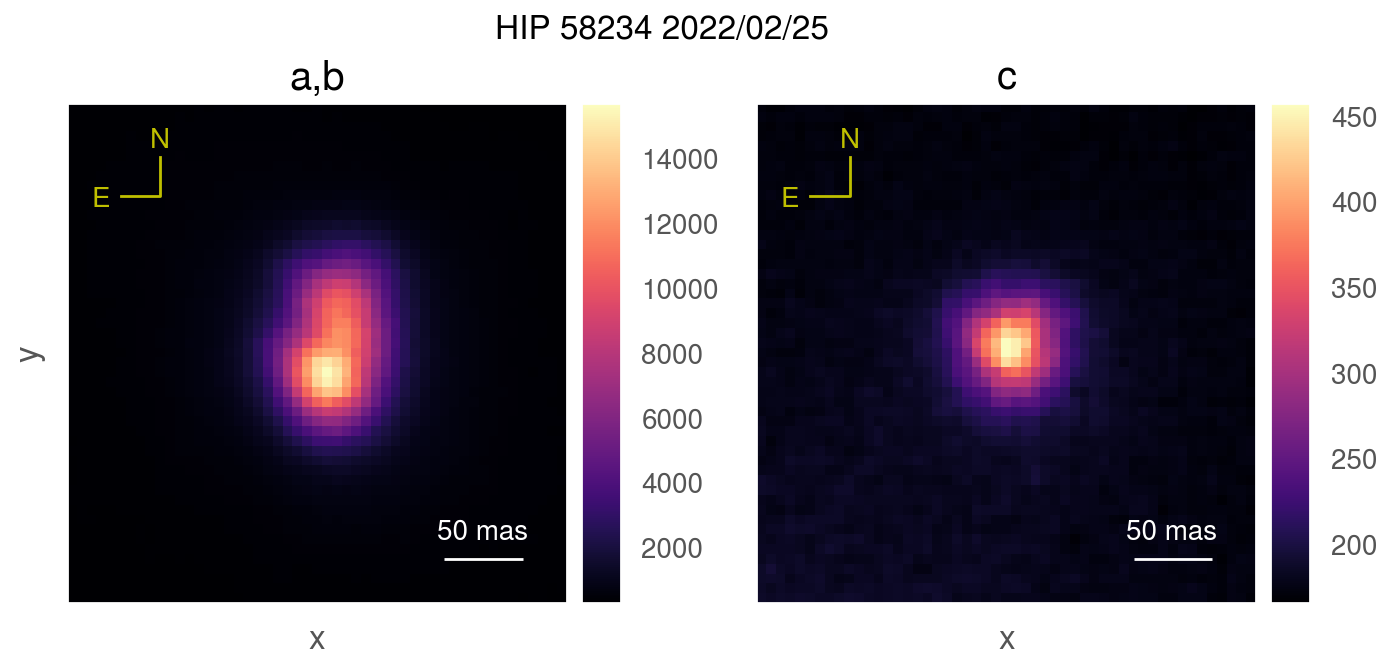

In [95]:
from vampires_dpp.satellite_spots import cutout_slice

fig, axes = pro.subplots(ncols=2, sharex=0, sharey=1)

cutout = cutout_slice(collapsed_frame, 50, center=(250, 256.5))
im = axes[0].imshow(collapsed_frame[cutout[0], cutout[1]])
axes[0].colorbar(im)
axes[0].format(title="a,b")

cutout = cutout_slice(collapsed_frame, 50, center=(360, 318))
im = axes[1].imshow(collapsed_frame[cutout[0], cutout[1]])
axes[1].colorbar(im)
axes[1].format(title="c")

axes.format(xticks=False, yticks=False, xlabel="x", ylabel="y")

## scale bar
for ax in axes:
    pad = 4
    length = 50 # mas
    xmax = 50 - pad
    xmin = xmax - length / 6.24
    ax.hlines(pad, xmin, xmax, c="w", lw=1)
    ax.annotate(f"{length} mas", (xmin + length/6.24/2 - 4.75, pad + 2), c="w")

## compass rose
for ax in axes:
    length = 4
    pad = 4
    ax.annotate("N", (length + pad, 50 - pad), c="y")
    ax.annotate("E", (pad - 2, 50 - pad - length - 2), c="y")
    xmin = pad + 1
    xmax = xmin + length
    ymax = 50 - pad - 1
    ymin = ymax - length
    ax.plot([xmin, xmax, xmax], [ymin, ymin, ymax], c="y", lw=1)


fig.suptitle("HIP 58234 2022/02/25");

## Hierarchical Modeling

Now we will fit the three stars using analytical PSF models and extract the position of the two companions. From the positions, we will calculate the separation on sky and the position angle.

For our models, we will use two-dimensional Moffat models which have shared shape parameters, since we expect the PSF to be invariant over the field (a good enough approximation).

In [ ]:
from astropy.modeling import models, fitting

star_a = models.Moffat2D(x_0=256.5, y_0=250, gamma=4, )